In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
rootdir = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow'

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
name = 'banana'
if name == 'corr-normal':
    ref_moments = {'moment_1': np.zeros(50), 'moment_2': np.ones(50)}
elif name == 'banana':
    ref_moments = {'moment_1': np.zeros(3), 'moment_2': np.array([1., 2.5, 1.])}
    ref_moments_1 = ref_moments['moment_1']
    ref_moments_2 = ref_moments['moment_2']
else:
    filename = f'/mnt/home/sliu1/normalizing_flows/qmc_flow/stan_models/moments_{name}_chain_20_warmup_25000_nsample_50000.pkl'
    with open(filename, 'rb') as f:
        moments = pickle.load(f)
    ref_moments_1 = moments['moment_1'].mean(0)
    ref_moments_1_var = moments['moment_1'].var(0)
    ref_moments_2 = moments['moment_2'].mean(0)
date = '2024-08-27'
path = os.path.join(rootdir, date, name)
max_deg = 3
num_layers = 3
results = {}
losses = {}
ESSs = {}
for method in ['mc', 'rqmc']:
    for m in [6, 9, 12]:
        nsample = 2**m
        for max_iter in [200]:
            for seed in range(20):
                filename = os.path.join(path, f'composite_rkl_{method}_n_{nsample}_deg_{max_deg}_layer_{num_layers}_iter_{max_iter}_{seed}.pkl')
                if not os.path.exists(filename):
                    continue
                with open(filename, 'rb') as f:
                    res = pickle.load(f)
                # mse_1 = np.mean((res['moments'][-1][0] - ref_moments_1)**2)
                # mse_2 = np.mean((res['moments'][-1][1] - ref_moments_2)**2)
                mse_1 = np.nanmean((res['moment'][0] - ref_moments_1)**2)
                results[(method, m, max_iter, seed)] = mse_1
                ESSs[(method, m, max_iter, seed)] = res['ess']
                
                # losses[(method, m)] = res['losses'] + [res['losses'][-1]] * (max_iter - len(res['losses']))

/tmp/ipykernel_1020629/1147993404.py:34: RuntimeWarning: Mean of empty slice
  mse_1 = np.nanmean((res['moment'][0] - ref_moments_1)**2)


In [3]:
ESSs

{('mc', 6, 200, 0): 24.214878267415678,
 ('mc', 6, 200, 1): nan,
 ('mc', 6, 200, 2): 18.90623684808479,
 ('mc', 6, 200, 3): 9.93383744248212,
 ('mc', 6, 200, 4): nan,
 ('mc', 9, 200, 0): 211.38872426586852,
 ('mc', 9, 200, 1): 84.4424562556913,
 ('mc', 9, 200, 2): 52.018909295622514,
 ('mc', 9, 200, 3): nan,
 ('mc', 9, 200, 4): 111.91736121293052,
 ('rqmc', 6, 200, 0): 21.93273522614303,
 ('rqmc', 6, 200, 1): 39.56282678364844,
 ('rqmc', 6, 200, 2): 59.40609748333709,
 ('rqmc', 6, 200, 3): 43.85589602938036,
 ('rqmc', 6, 200, 4): 52.27613763713556,
 ('rqmc', 9, 200, 0): 194.55219816111946,
 ('rqmc', 9, 200, 1): 210.50957368704698,
 ('rqmc', 9, 200, 2): 185.74321923689294,
 ('rqmc', 9, 200, 3): 191.64836902236635,
 ('rqmc', 9, 200, 4): 168.4605982926016}

Text(0.5, 0, 'Number of samples')

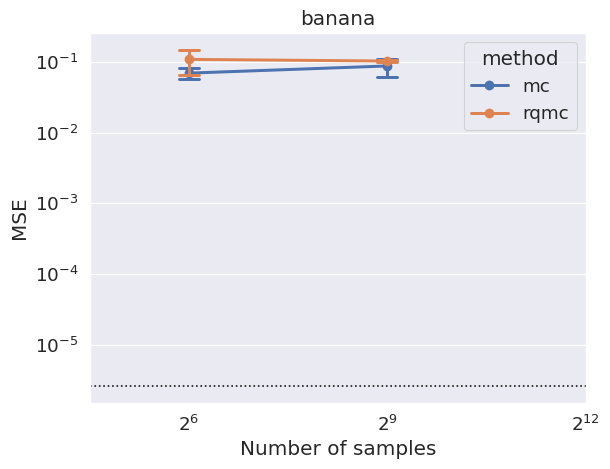

In [55]:
df = pd.DataFrame(results, index=['MSE']).T
df.reset_index(names=['method', 'm', 'max_iter', 'seed'], inplace=True)

sns.set_theme(context='paper', style='darkgrid', font_scale=1.5)
sns.pointplot(data=df, x='m', hue='method', y='MSE', capsize=.1, errorbar=('ci', 90))
plt.axhline(ref_moments_1_var.mean(), ls=':', color='k')
# sns.boxplot(data=df, x='m', hue='method', y='MSE')
plt.yscale('log', base=10)
plt.title(name)
plt.xticks(range(3), [f'$2^{{{m}}}$' for m in [6, 9, 12]])
plt.xlabel('Number of samples')
# plt.savefig(f'/mnt/home/sliu1/normalizing_flows/qmc_flow/plots/{name}_deg_{max_deg}_layer_{num_layers}_iter_{max_iter}_MSE_vs_n.pdf')

method      object
m            int64
max_iter     int64
seed         int64
MSE         object
dtype: object